In [44]:
import pandas as pd
import numpy as np
from numpy import hstack
import matplotlib
import matplotlib.pyplot as plt
import csv
import prophet
from prophet import Prophet

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split as tts
from sklearn import svm
from sklearn import metrics
from sklearn import linear_model

from datetime import datetime


!python --version
print('pandas', pd.__version__)
print('numpy ', np.__version__)
print('matplotlib ', matplotlib.__version__)
print('csv ', csv.__version__)
print('prophet ', prophet.__version__)
print('sklearn ', sklearn.__version__)

# from keras.models import Sequential
# from keras.layers import LSTM
# from keras.layers import Dense
# from keras.layers import Dropout
# from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
# from tensorflow.keras.models import Sequential

Python 3.7.13
pandas 1.3.5
numpy  1.21.6
matplotlib  3.2.2
csv  1.0
prophet  1.0
sklearn  1.0.2


In [3]:
# Point path to location of the following files in Drive:
# demand_kW
# inbound_loads.csv	
# outbound_loads.csv  
# pallet_history.csv	  
# weather.csv
# sample_of_upload.csv (template on kaggle)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
epoch_time = datetime(2015, 1, 1)

# Loading and pre-processing individual datasets

In [6]:
# Energy demand data
df_kw = pd.read_csv('/content/drive/MyDrive/aml/demand_kWtrain_val.csv')
df_kw = df_kw.rename(columns={'datetime_local':'datetime_UTC'})
df_kw['datetime_UTC'] = pd.to_datetime(df_kw['datetime_UTC'])

# Split data in train and test
df_kw_train = df_kw[~df_kw.isna().any(axis=1)]   
df_kw_test = df_kw[df_kw.isna().any(axis=1)]   

print('rows x columns ', df_kw.shape)
df_kw

rows x columns  (365349, 3)


,Unnamed: 0,datetime_UTC,demand_kW
0,0,2018-12-31 21:15:00,2064.101392
1,1,2018-12-31 21:30:00,1874.002081
2,2,2018-12-31 21:45:00,1988.168511
3,3,2018-12-31 22:00:00,2022.795943
4,4,2018-12-31 22:15:00,1986.981872
...,...,...,...
365344,365344,2021-12-13 17:55:00,NaN
365345,365345,2021-12-13 17:56:00,NaN
365346,365346,2021-12-13 17:57:00,NaN
365347,365347,2021-12-13 17:58:00,NaN


In [7]:
# Warehouse incomming loading data
df_in = pd.read_csv('/content/drive/MyDrive/aml/inbound_loads.csv')
for index in [0, 1, 2, 3, 4, 9, 14, 16, 17]:
  print('column removed ->', df_in.columns[index])
df_in = df_in.drop(df_in.columns[[0, 1, 2, 3, 4, 9, 14, 16, 17]], axis=1)


imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(df_in[df_in.columns[:6]])
df_in[df_in.columns[:6]] = imputer.transform(df_in[df_in.columns[:6]])

df_in = df_in[~df_in.isna().any(axis=1)]   

df_in['load_start_datetime'] = pd.to_datetime(df_in['load_start_datetime'])

df_in['load_finish_datetime'] = pd.to_datetime(df_in['load_finish_datetime'])

loading_time = (df_in['load_finish_datetime'] - df_in['load_start_datetime'])
df_in = df_in.assign(loading_time_s=loading_time)

df_in = df_in.drop(df_in.columns[[7]], axis=1)
df_in.rename(columns={'load_start_datetime':'datetime_UTC'}, inplace=True)
df_in['loading_time_s'] = df_in['loading_time_s'].apply(lambda x: x.total_seconds())

print('rows x columns ', df_in.shape)
df_in

Unnamed: 0
warehouse_order_number
customer_code
load_reference_number
carrier_code
weight_uom
signout_datetime
trailer_number
truck_signin_datetime
rows x columns  (46055, 9)


,front_temperature,middle_temperature,back_temperature,net_weight,case_quantity,pallet_count,datetime_UTC,dock_door_number,loading_time_s
0,-1.000,-1.000000,-1.000000,39000.0,1625.0,24.0,2019-02-11 04:42:00,59.0,540.0
1,4.000,4.000000,4.000000,29561.0,1232.0,26.0,2019-01-16 10:11:00,60.0,4560.0
2,1.629,1.906212,2.028734,39984.0,1666.0,24.0,2019-07-30 09:59:00,61.0,1140.0
3,-10.000,-7.000000,-6.000000,37800.0,1260.0,18.0,2019-01-10 08:51:00,58.0,420.0
4,3.000,4.000000,5.000000,41394.0,1380.0,18.0,2019-01-10 07:26:00,56.0,2520.0
...,...,...,...,...,...,...,...,...,...
56132,1.629,1.906212,2.028734,35610.0,3098.0,30.0,2022-01-02 22:16:00,50.0,1500.0
56135,1.629,1.906212,2.028734,31870.0,3187.0,25.0,2022-01-02 21:07:00,54.0,780.0
56137,1.629,1.906212,2.028734,36000.0,1200.0,26.0,2022-01-03 00:38:00,68.0,420.0
56138,1.629,1.906212,2.028734,30615.0,1134.0,28.0,2022-01-03 06:45:00,42.0,720.0


In [8]:
# Pallet data (useless)
df_pallet = pd.read_csv('/content/drive/MyDrive/aml/pallet_history.csv')
for index in [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14]:
  print('column removed ->', df_pallet.columns[index])
df_pallet = df_pallet.drop(df_pallet.columns[[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14]], axis=1)

df_pallet['received_date'] = pd.to_datetime(df_pallet['received_date'])

print('rows x columns ', df_pallet.shape)
df_pallet

Unnamed: 0
source_system_id
warehouse_facility_id
from_location_code
to_location_code
transaction_date
tran_type
quantity
work_type
final_pallet_code
warehouse_pallet_code
move_category
rows x columns  (4925535, 3)


,customer_code,lot_code,received_date
0,3610,1363587,2021-11-21 10:39:33
1,3610,1363587,2021-11-21 10:39:33
2,3610,1363587,2021-11-21 10:39:33
3,3610,1364144,2021-11-21 10:39:33
4,3610,1364144,2021-11-21 10:39:33
...,...,...,...
4925530,2319,1434138013,2019-12-31 02:07:16
4925531,2319,1434138013,2019-12-31 02:07:16
4925532,2319,1434138013,2019-12-31 02:07:16
4925533,2319,1434138013,2019-12-31 02:07:16


In [9]:
#Warehouse outgoing loading data
df_out = pd.read_csv('/content/drive/MyDrive/aml/outbound_loads.csv')
for index in [0, 1, 3, 4, 6, 11, 13, 14]:
  print('column removed ->', df_out.columns[index])
df_out = df_out.drop(df_out.columns[[0, 1, 3, 4, 6, 11, 13, 14]], axis=1)

imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(df_out[df_out.columns[:4]])
df_out[df_out.columns[:4]] = imputer.transform(df_out[df_out.columns[:4]])

df_out = df_out[~df_out.isna().any(axis=1)]   

df_out['load_start_datetime'] = pd.to_datetime(df_out['load_start_datetime'])

df_out['load_finish_datetime'] = pd.to_datetime(df_out['load_finish_datetime'])

loading_time = (df_out['load_finish_datetime'] - df_out['load_start_datetime'])
df_out = df_out.assign(loading_time_s=loading_time)

df_out = df_out.drop(df_out.columns[[5]], axis=1)
df_out.rename(columns={'load_start_datetime':'datetime_UTC'}, inplace=True)
df_out['loading_time_s'] = df_out['loading_time_s'].apply(lambda x: x.total_seconds())


# Rename columns so that the merge doesn't go wrong
df_out.rename(columns={'net_weight':'net_weight_out'}, inplace=True)
df_out.rename(columns={'case_quantity':'case_quantity_out'}, inplace=True)
df_out.rename(columns={'pallet_count':'pallet_count_out'}, inplace=True)
df_out.rename(columns={'dock_door_number':'dock_door_number_out'}, inplace=True)
df_out.rename(columns={'loading_time_s':'loading_time_s_out'}, inplace=True)



print('rows x columns ', df_out.shape)
df_out

Unnamed: 0
warehouse_order_number
load_reference_number
carrier_code
weight_uom
signout_datetime
trailer_number
truck_signin_datetime
rows x columns  (105512, 7)


,customer_code,net_weight_out,case_quantity_out,pallet_count_out,datetime_UTC,dock_door_number_out,loading_time_s_out
0,6907.0,3896.00,974.0,5.0,2019-01-04 04:16:18,62.0,193.0
3,8873.0,38391.00,1600.0,40.0,2019-01-09 16:33:01,37.0,7643.0
4,8873.0,30720.00,1920.0,48.0,2019-03-11 20:40:35,37.0,2485.0
5,8873.0,27516.00,1721.0,43.0,2019-02-06 16:21:26,40.0,4926.0
6,8873.0,43196.00,2000.0,46.0,2019-03-14 15:23:28,38.0,5176.0
...,...,...,...,...,...,...,...
112348,126053.0,222.84,16.0,1.0,2022-01-27 13:25:08,33.0,23.0
112359,126597.0,2250.00,90.0,2.0,2022-01-30 12:37:48,49.0,46.0
112360,899.0,38490.00,1212.0,21.0,2022-01-28 23:22:46,53.0,22112.0
112361,8873.0,39597.00,880.0,22.0,2022-01-29 13:07:00,21.0,2125.0


In [10]:
# Warehouse weather data
df_weather = pd.read_csv('/content/drive/MyDrive/aml/weather.csv')
df_weather = df_weather.drop(df_weather.columns[[0, 1]], axis=1)

imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(df_weather[df_weather.columns[:2]])
df_weather[df_weather.columns[:2]] = imputer.transform(df_weather[df_weather.columns[:2]])

df_weather = df_weather[~df_weather.isna().any(axis=1)]   

df_weather['datetime_UTC'] = pd.to_datetime(df_weather['datetime_UTC'])
df_weather['datetime_UTC'] = df_weather['datetime_UTC'] + pd.to_timedelta(df_weather['hour'], unit='h')
df_weather = df_weather.drop(df_weather.columns[[3]], axis=1)

print('rows x columns ', df_weather.shape)
df_weather

rows x columns  (328242, 3)


,Relative Humidity,Temperature,datetime_UTC
0,50.37,53.6,2019-01-01 18:00:00
1,50.37,53.6,2019-01-01 18:05:00
2,50.37,53.6,2019-01-01 18:10:00
3,50.37,53.6,2019-01-01 18:15:00
4,50.37,53.6,2019-01-01 18:20:00
...,...,...,...
328237,82.89,68.0,2022-01-01 16:35:00
328238,82.89,68.0,2022-01-01 16:40:00
328239,82.89,68.0,2022-01-01 16:45:00
328240,82.89,68.0,2022-01-01 16:50:00


# Grouping datasets

In [11]:
# Desired step size for testing and training sets
test_freq = '1min'
train_freq = '15min'

In [12]:
# Groupby and and impute for df_incomming test
df_in_grouped_1 = df_in.groupby(pd.Grouper(key='datetime_UTC', freq=test_freq)).mean()
df_in_grouped_1 = df_in_grouped_1.reset_index()
 
imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(df_in_grouped_1[df_in_grouped_1.columns[1:4]])
df_in_grouped_1[df_in_grouped_1.columns[1:4]] = imputer.transform(df_in_grouped_1[df_in_grouped_1.columns[1:4]])

df_in_grouped_1 = df_in_grouped_1.fillna(0)
df_in_grouped_1

,datetime_UTC,front_temperature,middle_temperature,back_temperature,net_weight,case_quantity,pallet_count,dock_door_number,loading_time_s
0,2018-12-30 06:33:00,-5.000000,-6.000000,-6.000000,42796.0,1950.0,24.0,1.0,11100.0
1,2018-12-30 06:34:00,1.625425,1.918099,2.047393,0.0,0.0,0.0,0.0,0.0
2,2018-12-30 06:35:00,1.625425,1.918099,2.047393,0.0,0.0,0.0,0.0,0.0
3,2018-12-30 06:36:00,1.625425,1.918099,2.047393,0.0,0.0,0.0,0.0,0.0
4,2018-12-30 06:37:00,1.625425,1.918099,2.047393,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
1584625,2022-01-03 16:58:00,1.625425,1.918099,2.047393,0.0,0.0,0.0,0.0,0.0
1584626,2022-01-03 16:59:00,1.625425,1.918099,2.047393,0.0,0.0,0.0,0.0,0.0
1584627,2022-01-03 17:00:00,1.625425,1.918099,2.047393,0.0,0.0,0.0,0.0,0.0
1584628,2022-01-03 17:01:00,1.625425,1.918099,2.047393,0.0,0.0,0.0,0.0,0.0


In [13]:
# Groupby and and impute for df_incomming train
df_in_grouped_15 = df_in.groupby(pd.Grouper(key='datetime_UTC', freq=train_freq)).mean()
df_in_grouped_15 = df_in_grouped_15.reset_index()
 
imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(df_in_grouped_15[df_in_grouped_15.columns[1:4]])
df_in_grouped_15[df_in_grouped_15.columns[1:4]] = imputer.transform(df_in_grouped_15[df_in_grouped_15.columns[1:4]])

df_in_grouped_15 = df_in_grouped_15.fillna(0)
df_in_grouped_15

,datetime_UTC,front_temperature,middle_temperature,back_temperature,net_weight,case_quantity,pallet_count,dock_door_number,loading_time_s
0,2018-12-30 06:30:00,-5.000000,-6.000000,-6.000000,42796.0,1950.0,24.0,1.0,11100.0
1,2018-12-30 06:45:00,1.647607,1.940032,2.071003,0.0,0.0,0.0,0.0,0.0
2,2018-12-30 07:00:00,1.647607,1.940032,2.071003,0.0,0.0,0.0,0.0,0.0
3,2018-12-30 07:15:00,1.647607,1.940032,2.071003,0.0,0.0,0.0,0.0,0.0
4,2018-12-30 07:30:00,1.647607,1.940032,2.071003,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
105638,2022-01-03 16:00:00,1.629000,1.906212,2.028734,36000.0,1200.0,25.0,56.0,840.0
105639,2022-01-03 16:15:00,1.647607,1.940032,2.071003,0.0,0.0,0.0,0.0,0.0
105640,2022-01-03 16:30:00,1.629000,1.906212,2.028734,23028.0,3426.0,43.0,66.5,2340.0
105641,2022-01-03 16:45:00,1.647607,1.940032,2.071003,0.0,0.0,0.0,0.0,0.0


In [14]:
# Groupby and and impute for df_outgoing test
df_out_grouped_1 = df_out.groupby(pd.Grouper(key='datetime_UTC', freq=test_freq)).mean()
df_out_grouped_1 = df_out_grouped_1.reset_index()
df_out_grouped_1 = df_out_grouped_1.fillna(0)
df_out_grouped_1

,datetime_UTC,customer_code,net_weight_out,case_quantity_out,pallet_count_out,dock_door_number_out,loading_time_s_out
0,2018-12-30 23:44:00,8873.0,3788.266667,570.333333,9.616968,35.0,6815.0
1,2018-12-30 23:45:00,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,2018-12-30 23:46:00,0.0,0.000000,0.000000,0.000000,0.0,0.0
3,2018-12-30 23:47:00,0.0,0.000000,0.000000,0.000000,0.0,0.0
4,2018-12-30 23:48:00,0.0,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...
1622239,2022-01-30 13:03:00,0.0,0.000000,0.000000,0.000000,0.0,0.0
1622240,2022-01-30 13:04:00,0.0,0.000000,0.000000,0.000000,0.0,0.0
1622241,2022-01-30 13:05:00,0.0,0.000000,0.000000,0.000000,0.0,0.0
1622242,2022-01-30 13:06:00,0.0,0.000000,0.000000,0.000000,0.0,0.0


In [15]:
# Groupby and and impute for df_outgoing train
df_out_grouped_15 = df_out.groupby(pd.Grouper(key='datetime_UTC', freq=train_freq)).mean()
df_out_grouped_15 = df_out_grouped_15.reset_index()
df_out_grouped_15 = df_out_grouped_15.fillna(0)
df_out_grouped_15

,datetime_UTC,customer_code,net_weight_out,case_quantity_out,pallet_count_out,dock_door_number_out,loading_time_s_out
0,2018-12-30 23:30:00,8873.0,3788.266667,570.333333,9.616968,35.0,6815.0
1,2018-12-30 23:45:00,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,2018-12-31 00:00:00,0.0,0.000000,0.000000,0.000000,0.0,0.0
3,2018-12-31 00:15:00,8873.0,7484.000000,248.000000,9.500000,34.0,1742.0
4,2018-12-31 00:30:00,0.0,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...
108146,2022-01-30 12:00:00,6910.0,37120.000000,2680.000000,26.000000,57.0,4898.0
108147,2022-01-30 12:15:00,7475.0,38321.090000,1680.000000,28.000000,90.0,3846.0
108148,2022-01-30 12:30:00,126597.0,2250.000000,90.000000,2.000000,49.0,46.0
108149,2022-01-30 12:45:00,874.0,40180.000000,1100.000000,20.000000,91.0,2249.0


In [16]:
# Groupby and and impute for df_weather test
df_weather_grouped_1 = df_weather.groupby(pd.Grouper(key='datetime_UTC', freq=test_freq)).mean()
df_weather_grouped_1 = df_weather_grouped_1.reset_index()
df_weather_grouped_1

,datetime_UTC,Relative Humidity,Temperature
0,2019-01-01 06:00:00,80.92,41.0
1,2019-01-01 06:01:00,NaN,NaN
2,2019-01-01 06:02:00,NaN,NaN
3,2019-01-01 06:03:00,NaN,NaN
4,2019-01-01 06:04:00,NaN,NaN
...,...,...,...
1578956,2022-01-01 17:56:00,NaN,NaN
1578957,2022-01-01 17:57:00,NaN,NaN
1578958,2022-01-01 17:58:00,NaN,NaN
1578959,2022-01-01 17:59:00,NaN,NaN


In [17]:
# Groupby and and impute for df_weather train
df_weather_grouped_15 = df_weather.groupby(pd.Grouper(key='datetime_UTC', freq=train_freq)).mean()
df_weather_grouped_15 = df_weather_grouped_15.reset_index()
df_weather_grouped_15


,datetime_UTC,Relative Humidity,Temperature
0,2019-01-01 06:00:00,84.833333,39.800
1,2019-01-01 06:15:00,86.790000,39.200
2,2019-01-01 06:30:00,86.790000,39.200
3,2019-01-01 06:45:00,86.477500,39.155
4,2019-01-01 07:00:00,NaN,NaN
...,...,...,...
105260,2022-01-01 17:00:00,NaN,NaN
105261,2022-01-01 17:15:00,NaN,NaN
105262,2022-01-01 17:30:00,NaN,NaN
105263,2022-01-01 17:45:00,NaN,NaN


# Merging datasets

In [18]:
# Create training set
new = df_kw_train.merge(df_weather_grouped_15)
new = new.merge(df_in_grouped_15)
new = new.merge(df_out_grouped_15)

imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(new[new.columns[3:5]])
new[new.columns[3:5]] = imputer.transform(new[new.columns[3:5]])

new_train = new[~new.isna().any(axis=1)]   

new_train

,Unnamed: 0,datetime_UTC,demand_kW,Relative Humidity,Temperature,front_temperature,middle_temperature,back_temperature,net_weight,case_quantity,pallet_count,dock_door_number,loading_time_s,customer_code,net_weight_out,case_quantity_out,pallet_count_out,dock_door_number_out,loading_time_s_out
0,35,2019-01-01 06:00:00,1594.005922,84.833333,39.800000,1.647607,1.940032,2.071003,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
1,36,2019-01-01 06:15:00,1881.341579,86.790000,39.200000,1.647607,1.940032,2.071003,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
2,37,2019-01-01 06:30:00,1917.410348,86.790000,39.200000,1.647607,1.940032,2.071003,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
3,38,2019-01-01 06:45:00,1606.903901,86.477500,39.155000,1.647607,1.940032,2.071003,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
4,39,2019-01-01 07:00:00,1691.625797,67.122908,66.549481,1.647607,1.940032,2.071003,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92563,273920,2021-10-11 05:00:00,2442.221000,67.927143,75.020000,1.647607,1.940032,2.071003,0.0,0.0,0.0,0.0,0.0,4723.5,26928.737,2118.5,20.0,22.0,3007.0
92564,273935,2021-10-11 05:15:00,2155.425000,67.990000,74.600000,1.629000,1.906212,2.028734,13079.5,468.0,26.5,76.5,390.0,0.0,0.000,0.0,0.0,0.0,0.0
92565,273950,2021-10-11 05:30:00,2200.405000,69.085000,74.000000,1.647607,1.940032,2.071003,0.0,0.0,0.0,0.0,0.0,66753.5,31403.500,2195.0,27.0,46.5,3407.5
92566,273965,2021-10-11 05:45:00,1998.399000,68.283750,74.570000,1.647607,1.940032,2.071003,0.0,0.0,0.0,0.0,0.0,8873.0,6950.500,457.5,4.0,24.0,3886.0


In [19]:
# Create testing set
new = df_kw_test.merge(df_weather_grouped_1)
new = new.merge(df_in_grouped_1)
new = new.merge(df_out_grouped_1)

imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(new[new.columns[3:5]])
new[new.columns[3:5]] = imputer.transform(new[new.columns[3:5]])
 
new_test = new[new.isna().any(axis=1)] 

new_test

,Unnamed: 0,datetime_UTC,demand_kW,Relative Humidity,Temperature,front_temperature,middle_temperature,back_temperature,net_weight,case_quantity,pallet_count,dock_door_number,loading_time_s,customer_code,net_weight_out,case_quantity_out,pallet_count_out,dock_door_number_out,loading_time_s_out
0,273988,2021-10-11 06:08:00,NaN,63.90748,60.377736,1.625425,1.918099,2.047393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,273989,2021-10-11 06:09:00,NaN,63.90748,60.377736,1.625425,1.918099,2.047393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,273990,2021-10-11 06:10:00,NaN,63.90748,60.377736,1.625425,1.918099,2.047393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,273991,2021-10-11 06:11:00,NaN,63.90748,60.377736,1.625425,1.918099,2.047393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,273992,2021-10-11 06:12:00,NaN,63.90748,60.377736,1.625425,1.918099,2.047393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91356,365344,2021-12-13 17:55:00,NaN,63.90748,60.377736,1.625425,1.918099,2.047393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91357,365345,2021-12-13 17:56:00,NaN,63.90748,60.377736,1.625425,1.918099,2.047393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91358,365346,2021-12-13 17:57:00,NaN,63.90748,60.377736,1.625425,1.918099,2.047393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91359,365347,2021-12-13 17:58:00,NaN,63.90748,60.377736,1.625425,1.918099,2.047393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Apply regression algorithms (commented out)

In [20]:
# def check_nan_cols(df):
#     cols_to_drop = []
#     for col in df:
#         col_nans = df[col].isna().sum()
#         print(col, col_nans)


# def plot_kw(df):
#     plt.figure(figsize=(15,5))
#     x_data, y_data = (df['Unnamed: 0'].values, df['demand_kW'].values)
#     plt.plot(x_data, y_data)
#     plt.ylabel('kW demand')
#     plt.xlabel('time (15 min)')
#     plt.show()

# def linear_regression(x_data_train, y_data_train, x_data_test):
#     regr = linear_model.LinearRegression()
#     regr.fit(x_data_train, y_data_train)

#     predicted = regr.predict(x_data_train)

#     y_data_predicted = regr.predict(x_data_test)
#     print(len(y_data_predicted))
#     return y_data_predicted




# # Gather column names for x
# cols = new_train.columns.to_list()
# cols.remove('demand_kW')
# cols.remove('Unnamed: 0')

# x_data_train = new_train[cols]
# y_data_train = new_train['demand_kW']
# y_data_train_pred = linear_regression(x_data_train, y_data_train, x_data_train)

# x_data_test = new_test[cols]
# y_data_test_predicted = linear_regression(x_data_train, y_data_train, x_data_test)

# print(y_data_test_predicted)

# X = new_train['Unnamed: 0']

# # Display linear regression training prediction
# plt.figure(figsize=(15,5))
# plt.plot(X.values, y_data_train.values, label = 'True demand')
# plt.plot(X.values, y_data_train_pred, label = 'Predicted demand', color='red')
# plt.ylabel('kW demand')
# plt.xlabel('time (15 min)')
# plt.legend()
# plt.show()

# Apply LSTM (commented out)

In [21]:
def split_sequences(in_X, in_y, n_steps):
  X, y = list(), list()
  for i in range(len(in_X)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the dataset
    if end_ix > len(in_X):
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = in_X[i:end_ix], in_y[end_ix-1]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)



# Gather column names for x
cols = new_train.columns.to_list()
# cols.remove('demand_kW')
cols.remove('Unnamed: 0')

temp = len(cols)
print(cols[:temp])
cols = cols[:temp]

x_data_train = new_train[cols]
y_data_train = new_train['demand_kW']

n_steps = 3
n_features = len(cols)
split_x_train, split_y_train = split_sequences(x_data_train, y_data_train, n_steps)

x_data_test = new_test[cols]
# Append n_steps final rows from train to test for burn in prediction in LSTM
for i in range(1, n_steps):
  x_data_test = pd.concat([x_data_test, x_data_train.iloc[[-i]]])


split_x_test,_ = split_sequences(x_data_test, y_data_train, n_steps)


print(x_data_test.shape)


['datetime_UTC', 'demand_kW', 'Relative Humidity', 'Temperature', 'front_temperature', 'middle_temperature', 'back_temperature', 'net_weight', 'case_quantity', 'pallet_count', 'dock_door_number', 'loading_time_s', 'customer_code', 'net_weight_out', 'case_quantity_out', 'pallet_count_out', 'dock_door_number_out', 'loading_time_s_out']
(91363, 18)


# Apply prophet predictor

In [22]:
model = Prophet()

cols.remove('datetime_UTC')
cols.remove('demand_kW')
cols.remove('customer_code')
for feature in cols:
	model.add_regressor(feature)

x_data_train = x_data_train.rename(columns={"datetime_UTC": "ds", "demand_kW": "y"})

model.fit(x_data_train)

train_forecast = model.predict(x_data_train)

print(train_forecast)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp3r4yaj42/qhl1_1kx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3r4yaj42/beu5ra_u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16679', 'data', 'file=/tmp/tmp3r4yaj42/qhl1_1kx.json', 'init=/tmp/tmp3r4yaj42/beu5ra_u.json', 'output', 'file=/tmp/tmpc_uotkqp/prophet_model-20220831145550.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:55:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:02:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


                       ds        trend   yhat_lower   yhat_upper  trend_lower  \
0     2019-01-01 06:00:00  2531.881150  1601.216701  2217.374004  2531.881150   
1     2019-01-01 06:15:00  2531.796214  1631.724305  2229.532530  2531.796214   
2     2019-01-01 06:30:00  2531.711278  1603.591592  2206.557839  2531.711278   
3     2019-01-01 06:45:00  2531.626341  1605.236834  2205.645607  2531.626341   
4     2019-01-01 07:00:00  2531.541405  1669.692780  2257.583887  2531.541405   
...                   ...          ...          ...          ...          ...   
92563 2021-10-11 05:00:00  2269.741087  2112.936210  2669.122888  2269.741087   
92564 2021-10-11 05:15:00  2269.764997  2099.850108  2719.062380  2269.764997   
92565 2021-10-11 05:30:00  2269.788907  2103.214895  2689.660626  2269.788907   
92566 2021-10-11 05:45:00  2269.812818  2101.062620  2706.219661  2269.812818   
92567 2021-10-11 06:00:00  2269.836728  2098.823426  2680.965763  2269.836728   

       trend_upper  Relativ

In [23]:
print(cols)
print(len(cols))

['Relative Humidity', 'Temperature', 'front_temperature', 'middle_temperature', 'back_temperature', 'net_weight', 'case_quantity', 'pallet_count', 'dock_door_number', 'loading_time_s', 'net_weight_out', 'case_quantity_out', 'pallet_count_out', 'dock_door_number_out', 'loading_time_s_out']
15


In [24]:
x_data_test = x_data_test.rename(columns={"datetime_UTC": "ds", "demand_kW": "y"})
test_forecast = model.predict(x_data_test)

In [25]:
y_hat = train_forecast.yhat.tolist()
y_test = test_forecast.yhat.tolist()[2:]

In [26]:
# # define model
# # model = Sequential()
# # model.add(LSTM(256, activation='relu', input_shape=(n_steps, n_features)))
# # model.add(Dense(1))
# # model.compile(optimizer='adam', loss='mse')


# def get_model(n_steps, n_features):
#   dropout = 0.2
#   lstm = 128
#   model = Sequential()
#   model.add(LSTM(units=lstm, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
#   model.add(Dropout(rate=dropout))

#   model.add(LSTM(units=lstm, activation='relu', return_sequences=True))
#   model.add(Dropout(rate=dropout))

#   model.add(LSTM(units=lstm, activation='relu', return_sequences=True))
#   model.add(Dropout(rate=dropout))

#   model.add(LSTM(units=lstm, activation='relu', return_sequences=False))
#   model.add(Dropout(rate=dropout))

#   model.add(Dense(1))

#   model.compile(loss="mean_squared_error",
#                 optimizer="adam"
#                 )

#   return model


# model = get_model(n_steps = n_steps, n_features = n_features)


# # fit model
# model.fit(split_x_train, split_y_train, epochs=50, verbose=1)

In [27]:
# y_hat = model.predict(split_x_train, verbose=1)
# y_hat = y_hat.flatten()
# y_hat = y_hat.tolist()

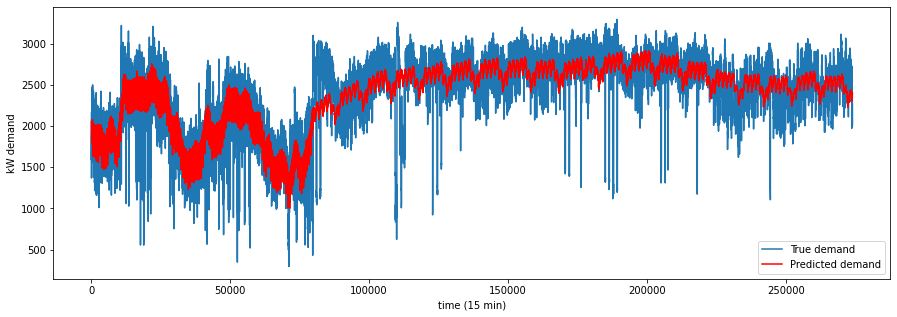

In [28]:
# insert n_steps values in front of the data
# filler_value = y_hat[0]
# for i in range(n_steps-1):
#   y_hat.insert(0,filler_value)

# print(y_hat)


X = new_train['Unnamed: 0']

# Display linear regression training prediction
plt.figure(figsize=(15,5))
plt.plot(X.values, y_data_train.values, label = 'True demand')
plt.plot(X.values, y_hat, label = 'Predicted demand', color='red')
plt.ylabel('kW demand')
plt.xlabel('time (15 min)')
plt.legend()
plt.show()

In [29]:
# print(split_x_test.shape)
# print(split_x_train.shape)
# y_test = model.predict(split_x_test, verbose=1).flatten()
# print(y_test)

In [30]:
# use training mean as testing prediction (best performance, lol)
# temp_y = np.repeat(2046.6461462276714, x_data_test.shape[0])

In [31]:
# Use mean of every 100 rows (performed bad)
# test_len = df_kw_test.shape[0]
# temp = df_kw_train.groupby(np.arange(len(df_kw_train))//10000).mean()['demand_kW'].to_list()
# repeats = int(test_len/len(temp))+1
# print(repeats)

# temp_y = []
# for value in temp:
#     temp_y.append(np.repeat(value,repeats))

# temp_y = np.array(temp_y).flatten().tolist()

# while len(temp_y) > test_len:
#     temp_y = np.delete(temp_y,-1)

# print(test_len)
# print(len(temp_y))


In [32]:
# Overwrite true target values in file with predicted target files for easy export
df_test_names = pd.read_csv('/content/drive/MyDrive/aml/sample_of_upload.csv')
print(df_test_names.shape, len(y_test))
df_pred = pd.DataFrame(data={'id': df_test_names['id'].tolist(), 'expected': y_test})
df_pred.to_csv('out.csv', index=False)
df_pred

(91361, 2) 91361


,id,expected
0,273988,2359.503631
1,273989,2359.616178
2,273990,2359.727207
3,273991,2359.836765
4,273992,2359.944901
...,...,...
91356,365344,1989.853537
91357,365345,1989.788753
91358,365346,1989.726297
91359,365347,1989.666201
